<a href="https://colab.research.google.com/github/AliJaffery12/Ball-Trajectory-Simulation-kalman-and-Particle-Filter-Sensor-Fusion/blob/main/kalmanFilter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

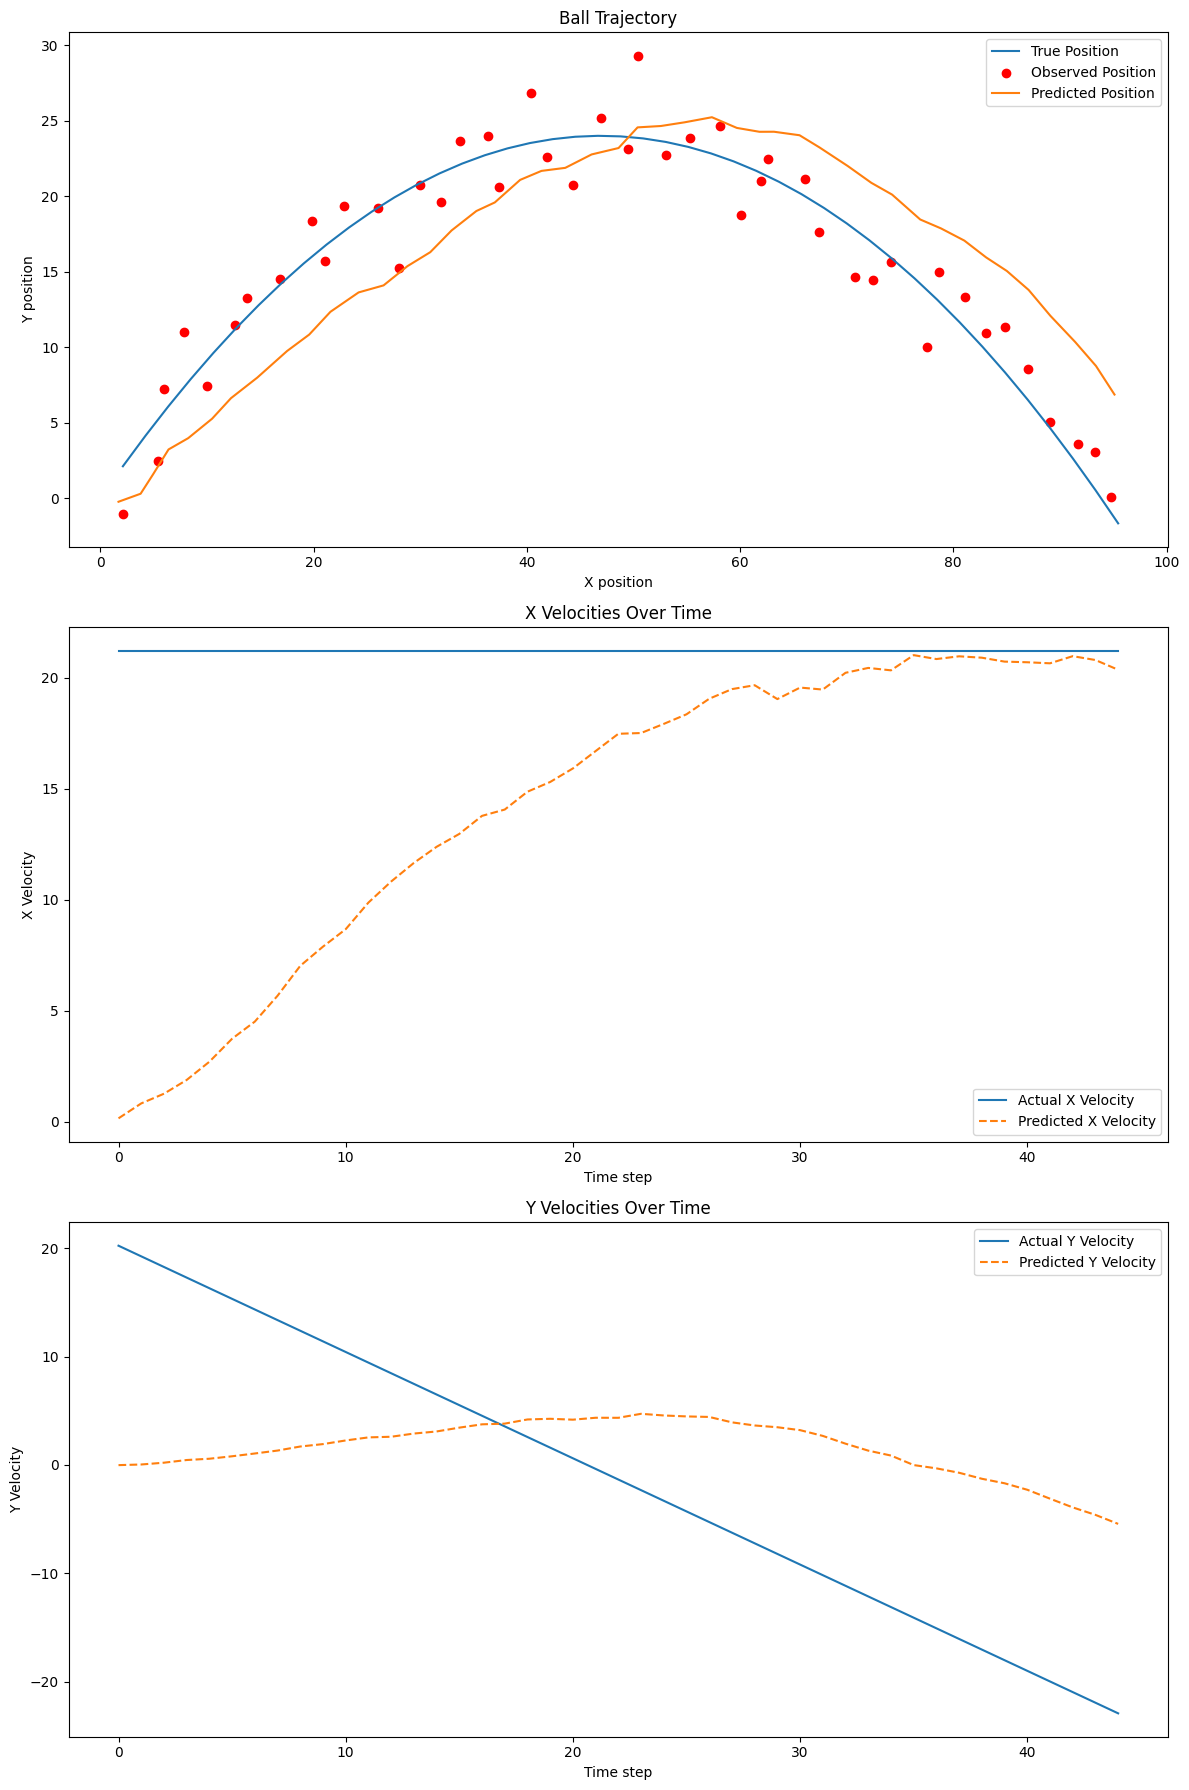

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Physics of the ball's motion
def simulate_ball_throw(launch_pos, launch_speed, launch_angle, dt, steps):
    angle_rad = np.radians(launch_angle)
    state = np.array([launch_pos[0], launch_pos[1], launch_speed * np.cos(angle_rad), launch_speed * np.sin(angle_rad)])
    g = 9.81
    true_positions = []
    true_velocities = []

    for _ in range(steps):
        state[0] += state[2] * dt  # x position update
        state[1] += state[3] * dt  # y position update
        state[3] -= g * dt         # y velocity update due to gravity

        true_positions.append(state[:2].copy())  # Store true position
        true_velocities.append(state[2:].copy())  # Store true velocity

        if state[1] < 0: break  # Stop if the ball hits the ground

    return np.array(true_positions), np.array(true_velocities)

# Kalman Filter implementation
class KalmanFilter:
    def __init__(self, F, H, R, Q, initial_state, initial_uncertainty):
        self.F = F  # State transition matrix
        self.H = H  # Observation matrix
        self.R = R  # Observation noise covariance
        self.Q = Q  # Process noise covariance
        self.state_estimate = initial_state
        self.uncertainty = initial_uncertainty

    def predict(self):
        # Prediction step
        self.state_estimate = np.dot(self.F, self.state_estimate)
        self.uncertainty = np.dot(self.F, np.dot(self.uncertainty, self.F.T)) + self.Q

    def update(self, observation):
        # Measurement update step
        y = observation - np.dot(self.H, self.state_estimate)
        S = np.dot(self.H, np.dot(self.uncertainty, self.H.T)) + self.R
        K = np.dot(np.dot(self.uncertainty, self.H.T), np.linalg.inv(S))
        self.state_estimate = self.state_estimate + np.dot(K, y)
        size = self.uncertainty.shape[0]
        self.uncertainty = (np.eye(size) - np.dot(K, self.H)) * self.uncertainty

# Settings for simulation
dt = 0.1  # Time step
steps = 100  # Number of steps
launch_pos = [0, 0]  # Launch position (x0, y0)
launch_speed = 30  # Launch speed (m/s)
launch_angle = 45  # Launch angle (degrees)

# Generate true trajectory and velocities
true_positions, true_velocities = simulate_ball_throw(launch_pos, launch_speed, launch_angle, dt, steps)

# Simulate noisy observations
observation_noise = np.array([0.5, 2])  # Noise in x and y observations
observations = true_positions + np.random.normal(0, observation_noise, true_positions.shape)

# Kalman Filter Setup
F = np.array([[1, 0, dt, 0],  # State transition matrix
              [0, 1, 0, dt],
              [0, 0, 1, 0],
              [0, 0, 0, 1]])

H = np.array([[1, 0, 0, 0],  # Observation matrix
              [0, 1, 0, 0]])

R = np.diag(observation_noise**2)  # Observation noise covariance
Q = np.eye(4) * 0.1  # Process noise covariance

initial_state = np.array([0, 0, 0, 0])  # Initial state estimate
initial_uncertainty = np.eye(4)  # Initial uncertainty

kf = KalmanFilter(F, H, R, Q, initial_state, initial_uncertainty)

# Running the Kalman Filter
predicted_positions = []
predicted_velocities = []

for observation in observations:
    kf.predict()
    kf.update(observation)
    predicted_positions.append(kf.state_estimate[:2])
    predicted_velocities.append(kf.state_estimate[2:])

predicted_positions = np.array(predicted_positions)
predicted_velocities = np.array(predicted_velocities)

# Visualization
fig, axs = plt.subplots(3, 1, figsize=(12, 18))

# Plot actual positions
axs[0].plot(true_positions[:, 0], true_positions[:, 1], label='True Position')
axs[0].scatter(observations[:, 0], observations[:, 1], c='red', label='Observed Position')
axs[0].plot(predicted_positions[:, 0], predicted_positions[:, 1], label='Predicted Position')
axs[0].set_xlabel('X position')
axs[0].set_ylabel('Y position')
axs[0].legend()
axs[0].set_title('Ball Trajectory')

# Plot actual and predicted X velocity
axs[1].plot(np.arange(len(true_velocities)), true_velocities[:, 0], label='Actual X Velocity')
axs[1].plot(np.arange(len(predicted_velocities)), predicted_velocities[:, 0], label='Predicted X Velocity', linestyle='--')
axs[1].set_xlabel('Time step')
axs[1].set_ylabel('X Velocity')
axs[1].legend()
axs[1].set_title('X Velocities Over Time')

# Plot actual and predicted Y velocity
axs[2].plot(np.arange(len(true_velocities)), true_velocities[:, 1], label='Actual Y Velocity')
axs[2].plot(np.arange(len(predicted_velocities)), predicted_velocities[:, 1], label='Predicted Y Velocity', linestyle='--')
axs[2].set_xlabel('Time step')
axs[2].set_ylabel('Y Velocity')
axs[2].legend()
axs[2].set_title('Y Velocities Over Time')

plt.tight_layout()
plt.show()
